# Data Preparation

In [1]:
import pandas as pd
import numpy as np
from scipy.stats import shapiro
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.impute import KNNImputer
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression, Lasso, Ridge, LassoCV, RidgeCV
from sklearn.pipeline import make_pipeline
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split

import warnings

In [2]:
warnings.filterwarnings("ignore")


In [3]:
def read_csv(file_path):
    # Read the CSV file
    df = pd.read_csv(file_path)

    # Return the DataFrame
    return df

# Usage example
df = read_csv('car_price.csv')
df.head()

,Unnamed: 0,car_name,car_prices_in_rupee,kms_driven,fuel_type,transmission,ownership,manufacture,engine,Seats
0,0,Jeep Compass 2.0 Longitude Option BSIV,10.03 Lakh,"86,226 kms",Diesel,Manual,1st Owner,2017,1956 cc,5 Seats
1,1,Renault Duster RXZ Turbo CVT,12.83 Lakh,"13,248 kms",Petrol,Automatic,1st Owner,2021,1330 cc,5 Seats
2,2,Toyota Camry 2.5 G,16.40 Lakh,"60,343 kms",Petrol,Automatic,1st Owner,2016,2494 cc,5 Seats
3,3,Honda Jazz VX CVT,7.77 Lakh,"26,696 kms",Petrol,Automatic,1st Owner,2018,1199 cc,5 Seats
4,4,Volkswagen Polo 1.2 MPI Highline,5.15 Lakh,"69,414 kms",Petrol,Manual,1st Owner,2016,1199 cc,5 Seats


# Data Cleaning

In [4]:
# Function that drops columns
def drop_columns(dataframe, columns_to_drop):

    # If a single column name is provided, convert it to a list
    if isinstance(columns_to_drop, str):
        columns_to_drop = [columns_to_drop]

    # Drop the specified columns
    modified_dataframe = dataframe.drop(columns=columns_to_drop, axis=1)

    return modified_dataframe

#example
df = drop_columns(df, ['Unnamed: 0'])
df.head()

,car_name,car_prices_in_rupee,kms_driven,fuel_type,transmission,ownership,manufacture,engine,Seats
0,Jeep Compass 2.0 Longitude Option BSIV,10.03 Lakh,"86,226 kms",Diesel,Manual,1st Owner,2017,1956 cc,5 Seats
1,Renault Duster RXZ Turbo CVT,12.83 Lakh,"13,248 kms",Petrol,Automatic,1st Owner,2021,1330 cc,5 Seats
2,Toyota Camry 2.5 G,16.40 Lakh,"60,343 kms",Petrol,Automatic,1st Owner,2016,2494 cc,5 Seats
3,Honda Jazz VX CVT,7.77 Lakh,"26,696 kms",Petrol,Automatic,1st Owner,2018,1199 cc,5 Seats
4,Volkswagen Polo 1.2 MPI Highline,5.15 Lakh,"69,414 kms",Petrol,Manual,1st Owner,2016,1199 cc,5 Seats


In [5]:
# Function that detects missing values per columns
def detect_missing_values(dataframe):

    # Get the total number of missing values in the dataframe
    missing_values = dataframe.isnull().sum()

    # Return the number of missing values
    return missing_values

#example
detect_missing_values(df)

car_name               0
car_prices_in_rupee    0
kms_driven             0
fuel_type              0
transmission           0
ownership              0
manufacture            0
engine                 0
Seats                  0
dtype: int64

In [6]:
#Function that converts column with strings to numerical values only
def convert_comma_to_dot(column):
    try:
        # Replace commas with periods
        column = column.replace(',', '.')

        return column
    except AttributeError:
        return None
    
def convert_price(column):
    num_value = float(column.split(" ")[0])

    if 'Crore' in column:
        return num_value * 10000000
    elif 'Lakh' in column:
        return num_value * 100000
    else:
        return num_value

# Remove the string in the engine column
def convert_engine(column):
    try:
        num_value = float(column.split(" ")[0])
        return num_value
    except ValueError:
        return None

# Remove the string in the power kms_driven
def convert_kms(column):
    try:
        # Remove commas and 'kms', then convert to integer
        return int(column.replace(',', '').replace(' kms', ''))
    except ValueError:
        return None
    
# Remove the string in the Seats column
def convert_seats(seats_str):
    try:
        return int(seats_str.replace(' Seats', ''))
    except ValueError:
        return None
    
# Extract the first word
def keep_first_word(input_string):
    all_words = input_string.split()
    if all_words:
        return all_words[0]
    else:
        return None

# Remove the string in the ownership column
def extract_first_integer(ownership_str):
    try:
        return int(''.join(filter(str.isdigit, ownership_str)))
    except ValueError:
        return None
    
def process_ownership(df):
    # Create a new column 'num_users' by applying the extract_first_integer function
    df['num_owners'] = df['ownership'].apply(extract_first_integer)

    # Drop the original 'ownership' column
    df.drop(columns=['ownership'], inplace=True)

    return df

# Apply the conversion function to the 'price' column
df['car_prices_in_rupee'] = df['car_prices_in_rupee'].apply(convert_comma_to_dot)
df['car_prices_in_rupee'] = df['car_prices_in_rupee'].apply(convert_price)

# Apply the conversion function to the 'kms_driven' column
df['kms_driven'] = df['kms_driven'].apply(convert_kms)

# Apply the conversion function to the 'engine' column
df['engine'] = df['engine'].apply(convert_engine)

# Apply the conversion function to the 'seats' column
df['Seats'] = df['Seats'].apply(convert_seats)

# Keep the first word of the column car
df['car_name'] = df['car_name'].apply(keep_first_word)

# Call the preprocess_data function to handle the ownership column
df = process_ownership(df)

# Display the modified DataFrame
df.head(20)

#example
#detect_missing_values(df)
        


,car_name,car_prices_in_rupee,kms_driven,fuel_type,transmission,manufacture,engine,Seats,num_owners
0,Jeep,1003000.0,86226,Diesel,Manual,2017,1956.0,5,1
1,Renault,1283000.0,13248,Petrol,Automatic,2021,1330.0,5,1
2,Toyota,1640000.0,60343,Petrol,Automatic,2016,2494.0,5,1
3,Honda,777000.0,26696,Petrol,Automatic,2018,1199.0,5,1
4,Volkswagen,515000.0,69414,Petrol,Manual,2016,1199.0,5,1
5,Volkswagen,766000.0,49719,Petrol,Automatic,2017,1197.0,5,1
6,Volkswagen,758000.0,43688,Petrol,Automatic,2017,1197.0,5,1
7,Honda,1160000.0,14470,Diesel,Manual,2021,1498.0,5,1
8,Honda,699000.0,21429,Petrol,Automatic,2015,1497.0,5,1
9,Renault,753000.0,31750,Petrol,Automatic,2017,1498.0,5,1


In [7]:
'''# Correlation Matrix
def correlation_heatmap(df, columns):
    corr = df[columns].corr()
    plt.figure(figsize=(10, 8))
    heatmap = sns.heatmap(corr, annot=True, cmap='viridis', fmt=".2f")
    heatmap.set_title('Correlation Matrix', fontdict={'fontsize': 18})
    plt.show()

# Example 
correlation_heatmap(df, ['car_prices_in_rupee', 'kms_driven','transmission','engine','manufacture','Seats','num_owners'])

#
all_columns = df.columns.tolist()  
correlation_heatmap(df, all_columns)
'''

'# Correlation Matrix\ndef correlation_heatmap(df, columns):\n    corr = df[columns].corr()\n    plt.figure(figsize=(10, 8))\n    heatmap = sns.heatmap(corr, annot=True, cmap=\'viridis\', fmt=".2f")\n    heatmap.set_title(\'Correlation Matrix\', fontdict={\'fontsize\': 18})\n    plt.show()\n\n# Example \ncorrelation_heatmap(df, [\'car_prices_in_rupee\', \'kms_driven\',\'transmission\',\'engine\',\'manufacture\',\'Seats\',\'num_owners\'])\n\n#\nall_columns = df.columns.tolist()  \ncorrelation_heatmap(df, all_columns)\n'

In [8]:
#example
detect_missing_values(df)

car_name               0
car_prices_in_rupee    0
kms_driven             0
fuel_type              0
transmission           0
manufacture            0
engine                 0
Seats                  0
num_owners             0
dtype: int64

In [10]:
#function for binary variables where we specify the true and false values
def columns_binary(df, column_names, true_value, false_value):
    for column_name in column_names:
        df[column_name] = df[column_name].replace({true_value: 1, false_value: 0})
    return df

df = columns_binary(df, ['transmission'], 'Automatic', 'Manual')

df.head(20)

,car_name,car_prices_in_rupee,kms_driven,fuel_type,transmission,manufacture,engine,Seats,num_owners
0,Jeep,1003000.0,86226,Diesel,0,2017,1956.0,5,1
1,Renault,1283000.0,13248,Petrol,1,2021,1330.0,5,1
2,Toyota,1640000.0,60343,Petrol,1,2016,2494.0,5,1
3,Honda,777000.0,26696,Petrol,1,2018,1199.0,5,1
4,Volkswagen,515000.0,69414,Petrol,0,2016,1199.0,5,1
5,Volkswagen,766000.0,49719,Petrol,1,2017,1197.0,5,1
6,Volkswagen,758000.0,43688,Petrol,1,2017,1197.0,5,1
7,Honda,1160000.0,14470,Diesel,0,2021,1498.0,5,1
8,Honda,699000.0,21429,Petrol,1,2015,1497.0,5,1
9,Renault,753000.0,31750,Petrol,1,2017,1498.0,5,1


In [ ]:
#example
detect_missing_values(df)

car_name               0
car_prices_in_rupee    0
kms_driven             0
fuel_type              0
transmission           0
manufacture            0
engine                 0
Seats                  0
num_owners             0
dtype: int64

In [ ]:
'''def one_hot_encode(df, columns_to_encode):
    df_encoded = pd.get_dummies(df, columns=columns_to_encode, drop_first=True)
    return df_encoded

# Define the columns to one-hot encode
columns_to_encode = ['fuel_type', 'car_name']

# Apply the one_hot_encode function
df = one_hot_encode(df, columns_to_encode)

#prepared_df.head()
df.head(20)'''

def one_hot_encode(df, columns_to_encode):
    df_encoded = pd.get_dummies(df, columns=columns_to_encode, drop_first=True)
    
    # Convert Boolean columns to integers (0s and 1s)
    boolean_columns = df_encoded.select_dtypes(include='bool').columns
    df_encoded[boolean_columns] = df_encoded[boolean_columns].astype(int)
    
    return df_encoded

# Define the columns to one-hot encode
columns_to_encode = ['fuel_type', 'car_name']

# Apply the one_hot_encode function
df = one_hot_encode(df, columns_to_encode)

df.head(20)  # Display the first 20 rows of the encoded DataFrame

,car_prices_in_rupee,kms_driven,transmission,manufacture,engine,Seats,num_owners,fuel_type_Diesel,fuel_type_Electric,fuel_type_Lpg,...,car_name_Mitsubishi,car_name_Nissan,car_name_Porsche,car_name_Premier,car_name_Renault,car_name_Skoda,car_name_Tata,car_name_Toyota,car_name_Volkswagen,car_name_Volvo
0,1003000.0,86226,0,2017,1956.0,5,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1283000.0,13248,1,2021,1330.0,5,1,0,0,0,...,0,0,0,0,1,0,0,0,0,0
2,1640000.0,60343,1,2016,2494.0,5,1,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,777000.0,26696,1,2018,1199.0,5,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,515000.0,69414,0,2016,1199.0,5,1,0,0,0,...,0,0,0,0,0,0,0,0,1,0
5,766000.0,49719,1,2017,1197.0,5,1,0,0,0,...,0,0,0,0,0,0,0,0,1,0
6,758000.0,43688,1,2017,1197.0,5,1,0,0,0,...,0,0,0,0,0,0,0,0,1,0
7,1160000.0,14470,0,2021,1498.0,5,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
8,699000.0,21429,1,2015,1497.0,5,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,753000.0,31750,1,2017,1498.0,5,1,0,0,0,...,0,0,0,0,1,0,0,0,0,0


In [ ]:
#example
detect_missing_values(df)

car_prices_in_rupee       0
kms_driven                0
transmission              0
manufacture               0
engine                    0
Seats                     0
num_owners                0
fuel_type_Diesel          0
fuel_type_Electric        0
fuel_type_Lpg             0
fuel_type_Petrol          0
car_name_BMW              0
car_name_Bentley          0
car_name_Chevrolet        0
car_name_Datsun           0
car_name_Fiat             0
car_name_Force            0
car_name_Ford             0
car_name_Honda            0
car_name_Hyundai          0
car_name_Isuzu            0
car_name_Jaguar           0
car_name_Jeep             0
car_name_Kia              0
car_name_Land             0
car_name_Lexus            0
car_name_MG               0
car_name_Mahindra         0
car_name_Maruti           0
car_name_Maserati         0
car_name_Mercedes-Benz    0
car_name_Mini             0
car_name_Mitsubishi       0
car_name_Nissan           0
car_name_Porsche          0
car_name_Premier    

In [ ]:
# Function that replaces missing values 

# Function to fill missing values with the mean
def column_fill_mean(df, column_name:str):
    df[column_name].fillna(df[column_name].mean(), inplace=True)
    return df

# fill missing values by random from the distribution
def distributed_fill(df, column_name):
    distribution = df[column_name].dropna()
    missing_count = df[column_name].isnull().sum()
    random_samples = np.random.choice(distribution, missing_count)
    df.loc[df[column_name].isnull(), column_name] = random_samples
    return df

# fill missing values with KNN
def column_fill_KNN(df, column_name:str):
    imputer = KNNImputer()
    imputed_data = imputer.fit_transform(df)
    df_temp = pd.DataFrame(imputed_data)
    df_temp.columns = df.columns
    df[column_name] = df_temp[column_name]
    return df



In [ ]:
df.head()


,car_prices_in_rupee,kms_driven,transmission,manufacture,engine,Seats,num_owners,fuel_type_Diesel,fuel_type_Electric,fuel_type_Lpg,...,car_name_Mitsubishi,car_name_Nissan,car_name_Porsche,car_name_Premier,car_name_Renault,car_name_Skoda,car_name_Tata,car_name_Toyota,car_name_Volkswagen,car_name_Volvo
0,1003000.0,86226,0,2017,1956.0,5,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1283000.0,13248,1,2021,1330.0,5,1,0,0,0,...,0,0,0,0,1,0,0,0,0,0
2,1640000.0,60343,1,2016,2494.0,5,1,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,777000.0,26696,1,2018,1199.0,5,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,515000.0,69414,0,2016,1199.0,5,1,0,0,0,...,0,0,0,0,0,0,0,0,1,0


# Data Exploration (graph (correlation and density), outliers, normality test,...)

In [ ]:
# Function to check outliers using quantiles
def check_outliers_quantiles(df):
    outliers = {}
    for column in df.columns:
        if pd.api.types.is_numeric_dtype(df[column]):
            q1 = df[column].quantile(0.10)
            q3 = df[column].quantile(0.90)
            iqr = q3 - q1
            lower_bound = q1 - 1.5 * iqr
            upper_bound = q3 + 1.5 * iqr

            outliers_count = ((df[column] < lower_bound) | (df[column] > upper_bound)).sum()
            outliers[column] = outliers_count

    print("Outliers in each numeric column based on quantiles method:")
    for col, count in outliers.items():
        print(f"Column '{col}': {count} outliers")

    return outliers

# Example
outliers_dict = check_outliers_quantiles(df)

Outliers in each numeric column based on quantiles method:
Column 'car_prices_in_rupee': 132 outliers
Column 'kms_driven': 22 outliers
Column 'transmission': 0 outliers
Column 'manufacture': 0 outliers
Column 'engine': 41 outliers
Column 'Seats': 0 outliers
Column 'num_owners': 96 outliers
Column 'fuel_type_Diesel': 0 outliers
Column 'fuel_type_Electric': 14 outliers
Column 'fuel_type_Lpg': 28 outliers
Column 'fuel_type_Petrol': 0 outliers
Column 'car_name_BMW': 172 outliers
Column 'car_name_Bentley': 1 outliers
Column 'car_name_Chevrolet': 82 outliers
Column 'car_name_Datsun': 25 outliers
Column 'car_name_Fiat': 17 outliers
Column 'car_name_Force': 1 outliers
Column 'car_name_Ford': 168 outliers
Column 'car_name_Honda': 498 outliers
Column 'car_name_Hyundai': 0 outliers
Column 'car_name_Isuzu': 4 outliers
Column 'car_name_Jaguar': 30 outliers
Column 'car_name_Jeep': 49 outliers
Column 'car_name_Kia': 61 outliers
Column 'car_name_Land': 50 outliers
Column 'car_name_Lexus': 10 outliers


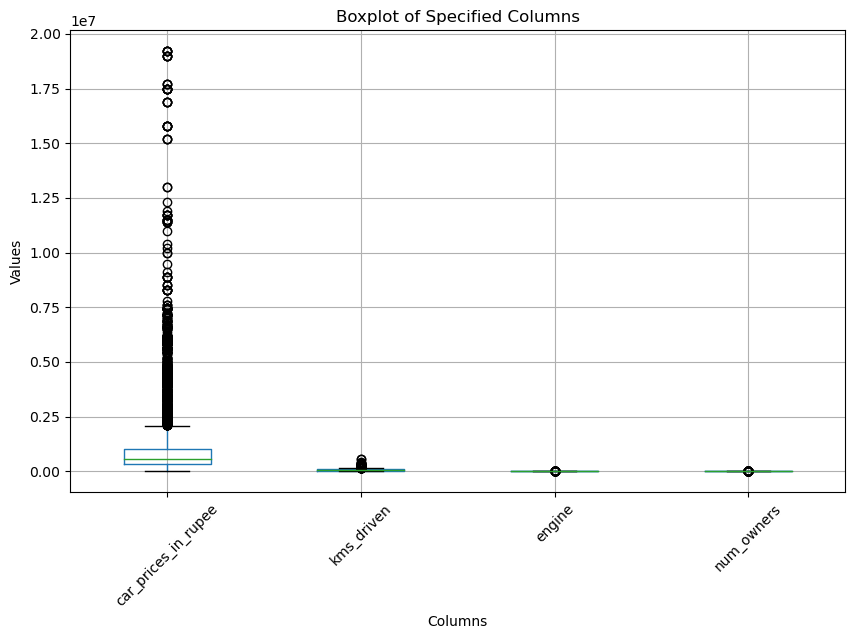

In [ ]:
# Function to create boxplots for specified columns
def create_boxplots(df, columns):
    fig, ax = plt.subplots(figsize=(10, 6))
    df.boxplot(column=columns, ax=ax)
    plt.title('Boxplot of Specified Columns')
    plt.ylabel('Values')
    plt.xlabel('Columns')
    plt.xticks(rotation=45)
    plt.show()
    
# Assuming 'df' is your DataFrame and 'selected_columns' is the list of columns to plot
create_boxplots(df, ['car_prices_in_rupee', 'kms_driven', 'engine', 'num_owners'])

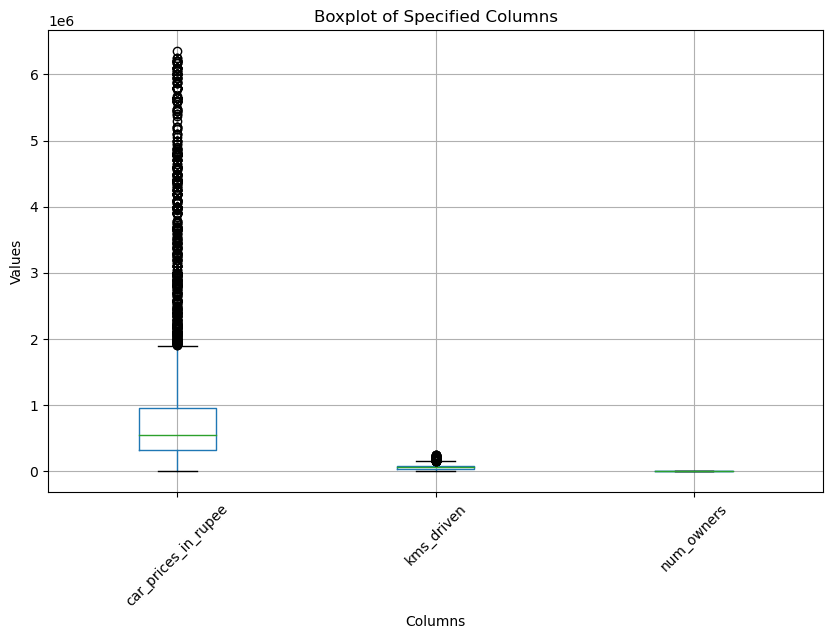

In [ ]:
# Handle outliers -> replace values with KNN
def handle_outliers_KNN(df, column_name:str):
    df_copy = df.copy()
    column_data = df_copy[[column_name]].values
    Q1 = np.percentile(column_data, 10)
    Q3 = np.percentile(column_data, 90)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    df_copy[column_name] = np.where((column_data < lower_bound) | (column_data > upper_bound), np.nan, column_data)

    df_copy = column_fill_KNN(df_copy, column_name)
    return df_copy

# Handle outliers -> replace values with mean
def handle_outliers_mean(df, column_name:str):
    df_copy = df.copy()
    column_data = df_copy[[column_name]].values
    Q1 = np.percentile(column_data, 10)
    Q3 = np.percentile(column_data, 90)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    df_copy[column_name] = np.where((column_data < lower_bound) | (column_data > upper_bound), np.nan, column_data)
    df_copy[column_name].fillna(df_copy[column_name].mean(), inplace=True)
    return df_copy

#example
df = handle_outliers_mean(df, 'car_prices_in_rupee')
df = handle_outliers_mean(df, 'kms_driven')
df = handle_outliers_mean(df, 'num_owners')

create_boxplots(df, ['car_prices_in_rupee', 'kms_driven', 'num_owners'])


In [ ]:
#Function to check the range of values in each column
def check_range(df):
    for column in df.select_dtypes(include=['int64', 'float64']).columns:
        min_val = df[column].min()
        max_val = df[column].max()
        print(f"{column}: Min = {min_val}, Max = {max_val}")


# Example 
ranges = check_range(df)


car_prices_in_rupee: Min = 35.0, Max = 6350000.0
kms_driven: Min = 250.0, Max = 249535.0
transmission: Min = 0, Max = 1
manufacture: Min = 1995, Max = 2022
engine: Min = 0.0, Max = 5950.0
Seats: Min = 2, Max = 8
num_owners: Min = 0.0, Max = 3.0


In [ ]:
df.head()

,car_prices_in_rupee,kms_driven,transmission,manufacture,engine,Seats,num_owners,fuel_type_Diesel,fuel_type_Electric,fuel_type_Lpg,...,car_name_Mitsubishi,car_name_Nissan,car_name_Porsche,car_name_Premier,car_name_Renault,car_name_Skoda,car_name_Tata,car_name_Toyota,car_name_Volkswagen,car_name_Volvo
0,1003000.0,86226.0,0,2017,1956.0,5,1.0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1283000.0,13248.0,1,2021,1330.0,5,1.0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
2,1640000.0,60343.0,1,2016,2494.0,5,1.0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,777000.0,26696.0,1,2018,1199.0,5,1.0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,515000.0,69414.0,0,2016,1199.0,5,1.0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


In [ ]:
# Function to check normality
def test_normality(data, column_name, alpha=0.05):
    # normality test
    stat, p = shapiro(data)
    result = f'Column "{column_name}" looks Gaussian (fail to reject H0)' if p > alpha else f'Column "{column_name}" is not normally distributed (reject H0)'
    interpretation = f'Column "{column_name}": Statistics={stat:.3f}, p={p:.3f}. {result}'
    print(interpretation)

# Usage example
test_normality(df['car_prices_in_rupee'], 'car_prices_in_rupee')
test_normality(df['kms_driven'], 'kms_driven')
test_normality(df['engine'], 'engine')
test_normality(df['manufacture'], 'manufacture')


Column "car_prices_in_rupee": Statistics=0.656, p=0.000. Column "car_prices_in_rupee" is not normally distributed (reject H0)
Column "kms_driven": Statistics=0.954, p=0.000. Column "kms_driven" is not normally distributed (reject H0)
Column "engine": Statistics=0.850, p=0.000. Column "engine" is not normally distributed (reject H0)
Column "manufacture": Statistics=0.965, p=0.000. Column "manufacture" is not normally distributed (reject H0)


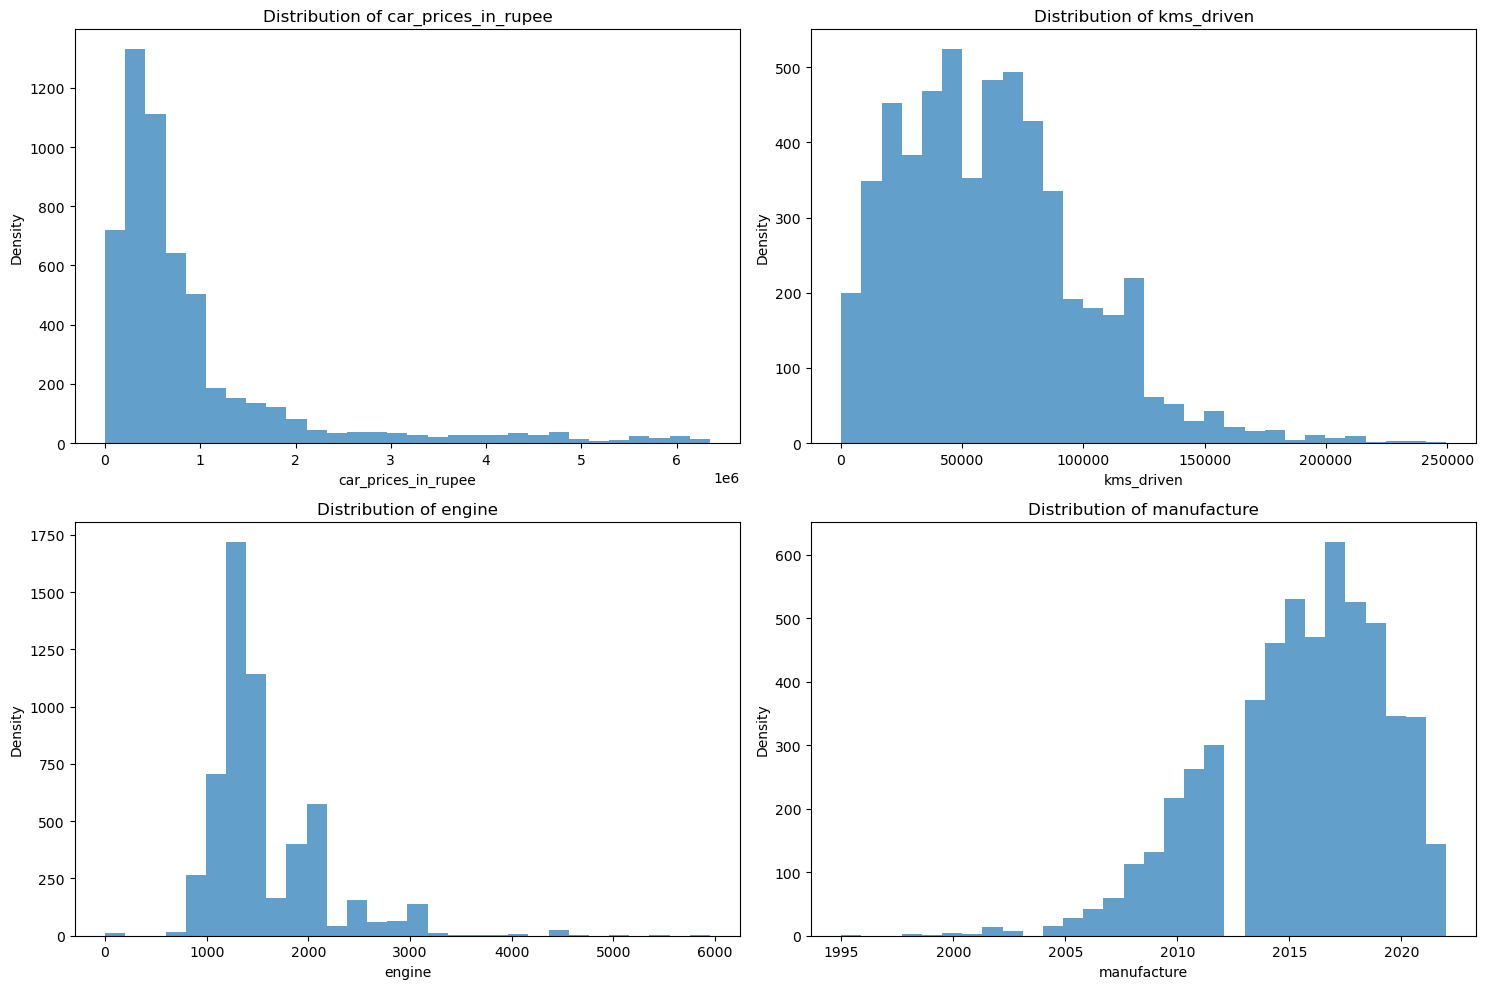

In [ ]:
# Plotting the distribution of the data

def plot_distribution(df, columns):
    num_cols = len(columns)
    num_rows = (num_cols // 2) + (num_cols % 2)
    fig, axes = plt.subplots(num_rows, 2, figsize=(15, num_rows * 5))
    axes = axes.flatten()

    for i, col in enumerate(columns):
        ax = axes[i]
        ax.hist(df[col], bins=30, alpha=0.7)
        ax.set_title(f'Distribution of {col}')
        ax.set_xlabel(col)
        ax.set_ylabel('Density')

    plt.tight_layout()
    plt.show()

# Usage example
plot_distribution(df, ['car_prices_in_rupee', 'kms_driven', 'engine','manufacture'])


# Data Transformation

In [ ]:
# normalization, standardization, log ttansformation
def scaling_normalization(df, column_name:str):
    df[column_name] = (df[column_name] - df[column_name].min()) / (df[column_name].max() - df[column_name].min())
    return df

def scaling_standardization(df, column_name:str):
    df[column_name] = (df[column_name] - df[column_name].mean()) / df[column_name].std()
    return df

def log_transformation(df, column_name:str):
    df[column_name] = np.log(df[column_name])
    return df

#square transformation
def square_transformation(df, column_name:str):
    df[column_name] = np.square(df[column_name])
    return df

#example transforamtions
#df = log_transformation(df, 'car_prices_in_rupee')
#df = log_transformation(df, 'kms_driven')
#df = scaling_normalization(df, 'engine')
#df = scaling_normalization(df, 'manufacture')

# Usage example
test_normality(df['car_prices_in_rupee'], 'car_prices_in_rupee')
test_normality(df['kms_driven'], 'kms_driven')
#test_normality(df['engine'], 'engine')
#test_normality(df['manufacture'], 'manufacture')


Column "car_prices_in_rupee": Statistics=0.656, p=0.000. Column "car_prices_in_rupee" is not normally distributed (reject H0)
Column "kms_driven": Statistics=0.954, p=0.000. Column "kms_driven" is not normally distributed (reject H0)


In [ ]:
#missing values
detect_missing_values(df)

car_prices_in_rupee       0
kms_driven                0
transmission              0
manufacture               0
engine                    0
Seats                     0
num_owners                0
fuel_type_Diesel          0
fuel_type_Electric        0
fuel_type_Lpg             0
fuel_type_Petrol          0
car_name_BMW              0
car_name_Bentley          0
car_name_Chevrolet        0
car_name_Datsun           0
car_name_Fiat             0
car_name_Force            0
car_name_Ford             0
car_name_Honda            0
car_name_Hyundai          0
car_name_Isuzu            0
car_name_Jaguar           0
car_name_Jeep             0
car_name_Kia              0
car_name_Land             0
car_name_Lexus            0
car_name_MG               0
car_name_Mahindra         0
car_name_Maruti           0
car_name_Maserati         0
car_name_Mercedes-Benz    0
car_name_Mini             0
car_name_Mitsubishi       0
car_name_Nissan           0
car_name_Porsche          0
car_name_Premier    

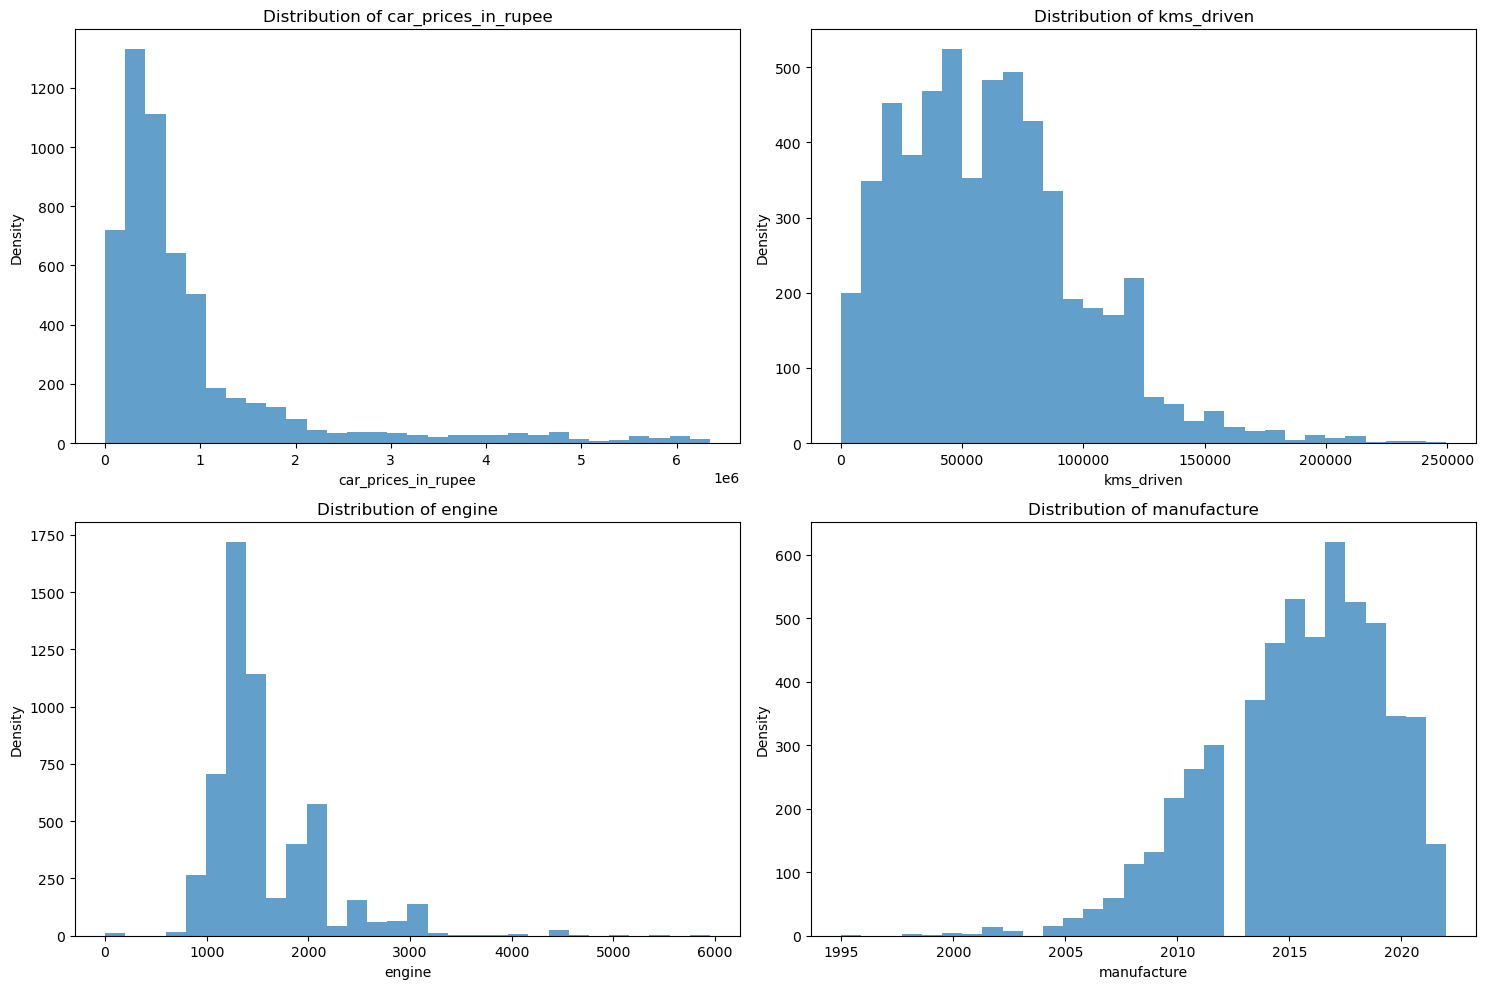

In [ ]:
# Usage example
plot_distribution(df, ['car_prices_in_rupee', 'kms_driven', 'engine','manufacture'])

In [ ]:
df.head()

,car_prices_in_rupee,kms_driven,transmission,manufacture,engine,Seats,num_owners,fuel_type_Diesel,fuel_type_Electric,fuel_type_Lpg,...,car_name_Mitsubishi,car_name_Nissan,car_name_Porsche,car_name_Premier,car_name_Renault,car_name_Skoda,car_name_Tata,car_name_Toyota,car_name_Volkswagen,car_name_Volvo
0,1003000.0,86226.0,0,2017,1956.0,5,1.0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1283000.0,13248.0,1,2021,1330.0,5,1.0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
2,1640000.0,60343.0,1,2016,2494.0,5,1.0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,777000.0,26696.0,1,2018,1199.0,5,1.0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,515000.0,69414.0,0,2016,1199.0,5,1.0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


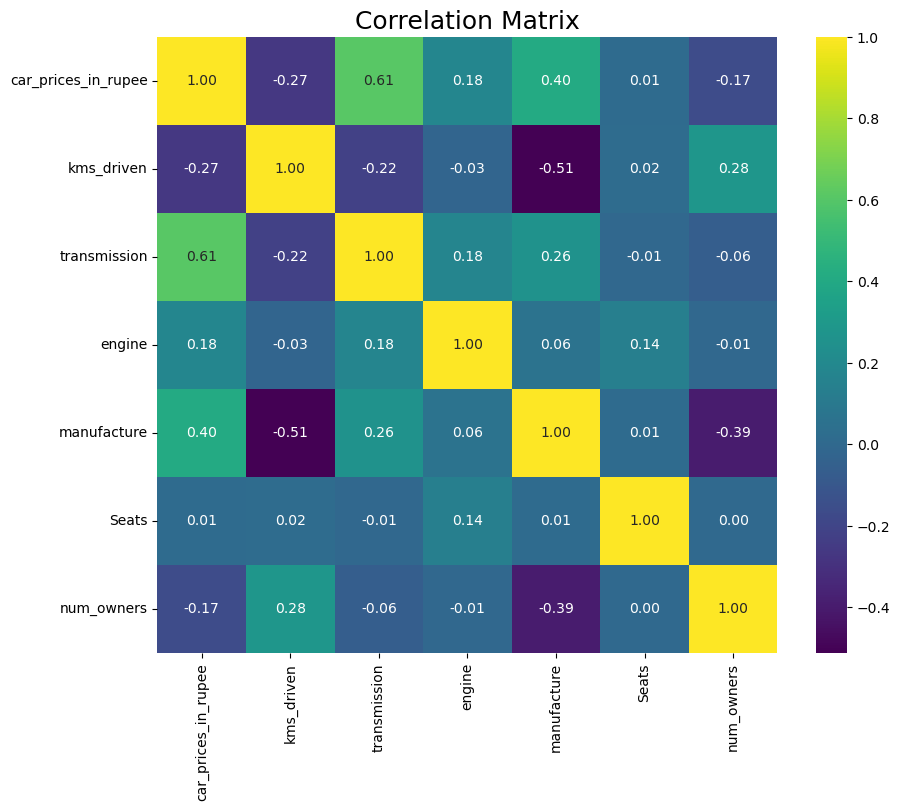

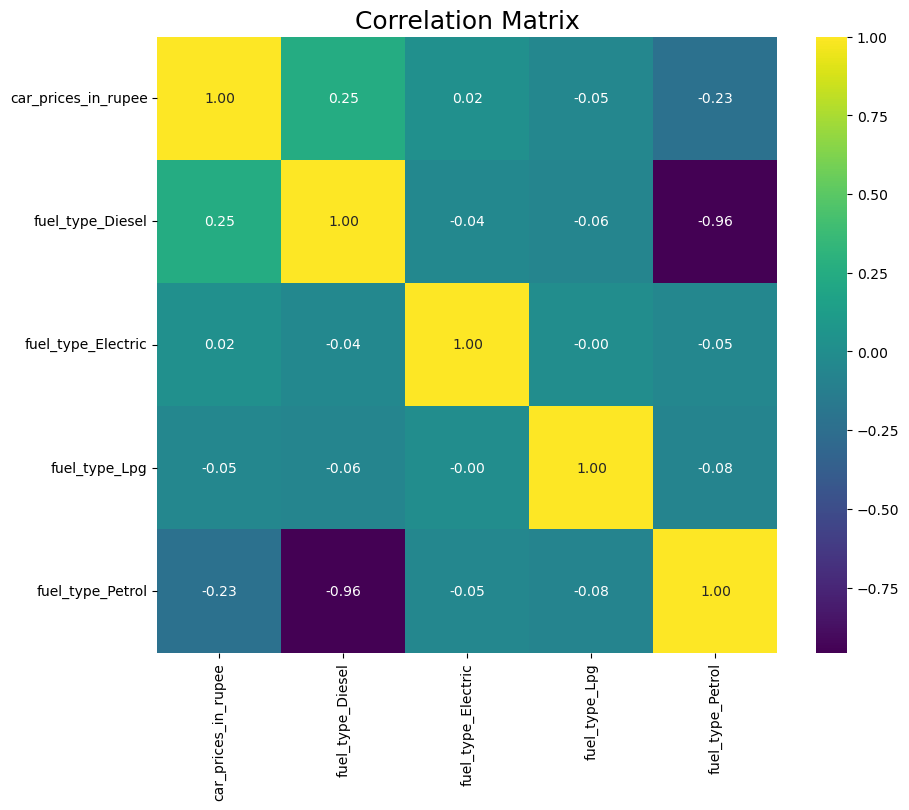

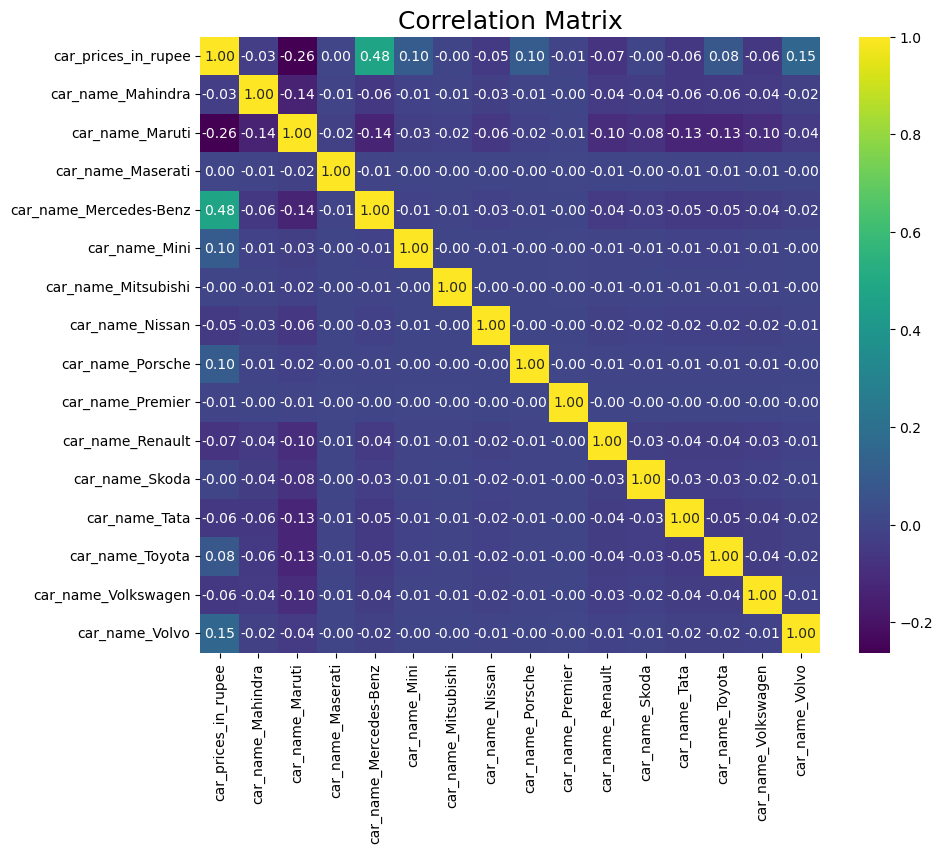

In [ ]:
# Correlation Matrix
def correlation_heatmap(df, columns):
    corr = df[columns].corr()
    plt.figure(figsize=(10, 8))
    heatmap = sns.heatmap(corr, annot=True, cmap='viridis', fmt=".2f")
    heatmap.set_title('Correlation Matrix', fontdict={'fontsize': 18})
    plt.show()

# Example with numerical variable
correlation_heatmap(df, ['car_prices_in_rupee', 'kms_driven','transmission','engine','manufacture','Seats','num_owners'])

# Fuel type
fuel_types_columns = ['car_prices_in_rupee','fuel_type_Diesel', 'fuel_type_Electric','fuel_type_Lpg','fuel_type_Petrol']
correlation_heatmap(df, fuel_types_columns)

#Car Company
first_column = df.columns[0]  # Get the first column name
last_15_columns = df.columns[-15:].tolist()  # Get the last 15 column names
columns_for_heatmap = [first_column] + last_15_columns  # Combine the first column with the last 15 columns
correlation_heatmap(df, columns_for_heatmap)


# Model

In [ ]:
print(df.shape)

(5512, 42)


In [ ]:
# Splitting into train and test sets

X = df.drop('car_prices_in_rupee', axis = 1) # Selecting independent features 
y = df['car_prices_in_rupee'] # Selecting target variable

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=123)

In [ ]:
print(X_test.shape)

(1654, 41)


In [ ]:
# Linear Regression
def linear_regression(X_train, y_train, X_test, y_test):
    linear = LinearRegression()
    linear.fit(X_train, y_train)
    y_pred = linear.predict(X_test)
    
    # Calculate accuracy
    mse = mean_squared_error(y_test, y_pred)
    rmse = mean_squared_error(y_test, y_pred, squared=False)
    mse_std = np.std(y_test - y_pred)
    r2 = r2_score(y_test, y_pred)   
    return mse, rmse, mse_std, r2, y_pred

#Lasso Regression
def lasso_regression(X_train, y_train, X_test, y_test, alphas=[0,1,2,3,4,5]):
    lasso = Lasso(alpha=alphas)
    lasso.fit(X_train, y_train)
    
    y_pred = lasso.predict(X_test)
        
    #Calculate accuracy
    mse = mean_squared_error(y_test, y_pred)
    rmse = mean_squared_error(y_test, y_pred, squared=False)
    mse_std = np.std(y_test - y_pred)
    r2 = r2_score(y_test, y_pred)
    
    return mse, rmse, mse_std, r2, y_pred

#Lasso Regression with Cross Validation
def lasso_regression_cv(X_train, y_train, X_test, y_test, cv=10):
    alphas = np.logspace(-4, 4, 100)  # Define a range of alpha values for optimization
    
    lasso_cv = LassoCV(alphas=alphas, cv=cv)
    lasso_cv.fit(X_train, y_train)
    
    best_alpha = lasso_cv.alpha_  # Get the optimized alpha
    
    # Train Lasso regression with the best alpha
    lasso = Lasso(alpha=best_alpha)
    lasso.fit(X_train, y_train)
    
    y_pred = lasso.predict(X_test)
    
    mse = mean_squared_error(y_test, y_pred)
    rmse = mean_squared_error(y_test, y_pred, squared=False)
    mse_std = np.std(y_test - y_pred)
    r2 = r2_score(y_test, y_pred)
    
    return mse, rmse, y_pred , r2, best_alpha

#Ridge Regression
def ridge_regression(X_train, y_train, X_test, y_test, alphas=[0.01,0.5,0.75,1,2]):
    ridge = Ridge(alpha=alphas)
    ridge.fit(X_train, y_train)
    
    y_pred = ridge.predict(X_test)
        
    #Calculate accuracy
    mse = mean_squared_error(y_test, y_pred)
    mse_std = np.std(y_test - y_pred)
    r2 = r2_score(y_test, y_pred)
    
    return mse, mse_std, r2, y_pred

#Ridge Regression with Cross Validation
def ridge_regression_cv(X_train, y_train, X_test,y_test, cv=10):
    alphas = np.logspace(-4, 4, 100)  # Define a range of alpha values for optimization
    
    ridge_cv = RidgeCV(alphas=alphas, cv=cv)
    ridge_cv.fit(X_train, y_train)
    
    best_alpha = ridge_cv.alpha_  # Get the optimized alpha
    
    # Train Ridge regression with the best alpha
    ridge = Ridge(alpha=best_alpha)
    ridge.fit(X_train, y_train)
    
    y_pred = ridge.predict(X_test)
    
    #Calculate accuracy
    mse = mean_squared_error(y_test, y_pred)
    rmse = mean_squared_error(y_test, y_pred, squared=False)
    mse_std = np.std(y_test - y_pred)
    r2 = r2_score(y_test, y_pred)
    
    return mse, rmse, y_pred, r2, best_alpha

# Gradient Boosting Regression
def gradient_boosting(X_train, y_train, X_test, y_test, n_estimators=100, learning_rate=0.1, max_depth=4):
    gb_regressor = GradientBoostingRegressor(n_estimators=n_estimators, learning_rate=learning_rate, max_depth=max_depth)
    gb_regressor.fit(X_train, y_train)
    
    y_pred = gb_regressor.predict(X_test)
    
    #Calculate accuracy
    mse = mean_squared_error(y_test, y_pred)
    mse_std = np.std(y_test - y_pred)
    r2 = r2_score(y_test, y_pred)
    
    return mse, mse_std, r2, y_pred

def gradient_boosting_cv(X_train, y_train, X_test, y_test, cv=10):
    
    print('This process might take a few minutes.')
    
    param_grid = {
            'n_estimators': [100],
            'learning_rate': [0.05, 0.1],
            'max_depth': [4, 6],
            'min_samples_split': [10, 20],
            'min_samples_leaf': [1,3],
            'subsample': [0.8, 1.0]
        }

    gb_regressor = GradientBoostingRegressor()
    grid_search = GridSearchCV(estimator=gb_regressor, param_grid=param_grid, cv=cv, scoring='neg_mean_squared_error', verbose=1, n_jobs=-1)
    
    grid_search.fit(X_train, y_train)
    best_gb_model = grid_search.best_estimator_
    
    y_pred = best_gb_model.predict(X_test)
    
    # Calculate accuracy
    mse = mean_squared_error(y_test, y_pred)
    rmse = mean_squared_error(y_test, y_pred, squared=False)
    mse_std = np.std(y_test - y_pred)
    r2 = r2_score(y_test, y_pred)
    
    # Retrieve best parameters
    best_params = grid_search.best_params_
    
    # Store results in a dictionary
    results = {
        'mse': mse,
        'rmse': rmse,
        'mse_std': mse_std,
        'r2': r2,
        'best_params': best_params,
        'y_pred': y_pred
    }
    
    return mse, rmse, y_pred, r2, best_params


# Fine tuning functions


# Running every model

In [ ]:
# Function that runs every model
import warnings

def best_model(X_train, y_train, X_test, y_test):
    
    # Suppress warnings
    warnings.filterwarnings("ignore")
    
    # Models without Cross Validation defined separately
    # Linear Regression
    linear_mse, linear_rmse,_, linear_r2, y_pred = linear_regression(X_train, y_train, X_test, y_test)
    print(f"Linear Regression MSE: {linear_mse:.3f} and RMSE:{linear_mse:.3f}  with an R2 of {linear_r2:.3f}")
    
    # Lasso_cv Model
    lasso_cv_mse, lasso_cv_rmse, y_pred, lasso_cv_r2, best_alpha= lasso_regression_cv(X_train, y_train, X_test, y_test)
    print(f"Lasso Model with Cross Validation MSE: {lasso_cv_mse:.3f} and RMSE:{lasso_cv_rmse:.3f} with an R2 of {lasso_cv_r2:.3f} (alpha={best_alpha:.3f})")
    
    # Ridge_cv Model
    ridge_cv_mse, ridge_cv_rmse,y_pred, ridge_cv_r2, best_alpha = ridge_regression_cv(X_train, y_train, X_test, y_test)
    print(f"Ridge Model with Cross Validation MSE: {ridge_cv_mse:.3f} and RMSE:{ridge_cv_rmse:.3f} with an R2 of {ridge_cv_r2:.3f} (alpha={best_alpha:.3f}))")

    # Gboost Model CV
    gboost_cv_mse, gboost_cv_rmse, y_pred, gboost_cv_r2, best_params = gradient_boosting_cv(X_train, y_train, X_test, y_test)
    print(f"Gradient Boosting Model with Cross Validation MSE: {gboost_cv_mse:.3f} and RMSE:{gboost_cv_rmse:.3f} with an R2 of {gboost_cv_r2:.3f} (hyperparamaters: {best_params}))")
    
    # Find the best model based on MSE (add more models and more metrics here)
    min_mse = min(linear_mse,lasso_cv_mse,  ridge_cv_mse,gboost_cv_mse)
    min_rmse = min(linear_rmse, lasso_cv_rmse,  ridge_cv_rmse, gboost_cv_rmse)
    min_r2 = min(linear_r2, lasso_cv_r2,  ridge_cv_r2, gboost_cv_r2)

    # Find the best model based on MSE (add more models and more metrics here)
    if min_mse == linear_mse:
        best_model = 'Linear Regression'
        min_rmse = linear_rmse
        min_r2 = linear_r2

    elif min_mse == lasso_cv_mse:
        best_model = 'Lasso'
        min_rmse = lasso_cv_rmse
        min_r2 = lasso_cv_r2

    elif min_mse == ridge_cv_mse:
        best_model = 'Ridge'
        min_rmse = ridge_cv_rmse
        min_r2 = ridge_cv_r2

    elif min_mse == gboost_cv_mse:
        best_model = 'Gradient Boosting'
        min_rmse = gboost_cv_rmse
        min_r2 = gboost_cv_r2

    # Print the best model and its metrics (add more metrics if needed)
    print(f"The best model is: \033[1m\033[3m{best_model} with an MSE of {min_mse:.3f}, RMSE of {min_rmse:.3f} and an R2 of {min_r2:.3f}\033[0m")

    return best_model

In [ ]:
best_model = best_model(X_train, y_train, X_test, y_test)

Linear Regression MSE: 442497139407.946 and RMSE:442497139407.946  with an R2 of 0.641
Lasso Model with Cross Validation MSE: 442518703006.899 and RMSE:665220.793 with an R2 of 0.641 (alpha=31.257)
Ridge Model with Cross Validation MSE: 442931371433.803 and RMSE:665530.894 with an R2 of 0.641 (alpha=0.521))
This process might take a few minutes.
Fitting 10 folds for each of 32 candidates, totalling 320 fits
Gradient Boosting Model with Cross Validation MSE: 239791638185.375 and RMSE:489685.244 with an R2 of 0.806 (hyperparamaters: {'learning_rate': 0.1, 'max_depth': 6, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 100, 'subsample': 0.8}))
The best model is: Gradient Boosting with an MSE of 239791638185.375, RMSE of 489685.244 and an R2 of 0.806


### Saving the predictions to a CSV

In [ ]:
import pandas as pd

class PredictionsToCSV:
    def __init__(self, path_directory):
        self.path_directory = path_directory
    
    def save_predictions_to_csv(self, X_train, y_train, X_test, y_test):
        
        # Suppress warnings
        warnings.filterwarnings("ignore")
        
        # Models without Cross Validation (add more models here)
        # Linear Regression
        linear_mse, _, _, _, y_pred = linear_regression(X_train, y_train, X_test, y_test)
                
        # Lasso_cv Model
        lasso_cv_mse, _, y_pred, _, _ = lasso_regression_cv(X_train, y_train, X_test, y_test)
        
        # Ridge_cv Model
        ridge_cv_mse, _, y_pred, _, _ = ridge_regression_cv(X_train, y_train, X_test, y_test)
        
        # Gboost Model CV
        gboost_cv_mse, _, y_pred, _, _ = gradient_boosting_cv(X_train, y_train, X_test, y_test)
        
        # Find the best model based on MSE (uncomment the code below if you want to use the RMSE or R2 as the metric)
        min_mse = min(linear_mse, lasso_cv_mse, ridge_cv_mse, gboost_cv_mse)
        #min_rmse = min(linear_rmse, lasso_cv_rmse, ridge_cv_rmse, gboost_cv_rmse)
        #min_r2 = min(linear_r2, lasso_cv_r2, ridge_cv_r2, gboost_cv_r2)

        # Find the best model based on MSE (change to RMSE or R2 if needed)
        if min_mse == linear_mse:
            best_model = 'Linear_Regression'
        elif min_mse == lasso_cv_mse:
            best_model = 'Lasso'
        elif min_mse == ridge_cv_mse:
            best_model = 'Ridge'
        elif min_mse == gboost_cv_mse:
            best_model = 'Gradient_Boosting'

        print(f"The best model selected is '{best_model}'.")
        print("Predictions are now being computed.")

        # Perform prediction using the best model
        if best_model == 'Linear_Regression':
            _, _, _, _, y_pred = linear_regression(X_train, y_train, X_test, y_test)
        elif best_model == 'Lasso':
            _, _, y_pred, _, _ = lasso_regression_cv(X_train, y_train, X_test, y_test)
        elif best_model == 'Ridge':
            _, _, y_pred, _, _ = ridge_regression_cv(X_train, y_train, X_test, y_test)
        elif best_model == 'Gradient_Boosting':
            _, _, y_pred, _, _ = gradient_boosting_cv(X_train, y_train, X_test, y_test)
        
        # Create a DataFrame with the predictions
        predictions_df = pd.DataFrame({'Actual': y_test, 'Predictions': y_pred})
        
        # Define the path to save the CSV file
        csv_path = f"{self.path_directory}/{best_model}_predictions.csv"
        
        # Save predictions to a CSV file
        predictions_df.to_csv(csv_path, index=False)
        print(f"Predictions from the best model '{best_model}' saved to '{csv_path}'")



In [ ]:
#Saving predictions to CSV
path_directory = '/Users/mathieu26/Desktop/DSDM-BSE/Term_1/Computing_for_Data_Science/Final_Project/Used_Car_Predictor-2'

# Create an instance of the PredictionsToCSV class
predictions_save = PredictionsToCSV(path_directory=path_directory)

# Save predictions to a CSV file
predictions_save.save_predictions_to_csv(X_train, y_train, X_test, y_test)